# Data Preprocessing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter        
from lifelines.statistics import logrank_test, pairwise_logrank_test, multivariate_logrank_test 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
import time

In [3]:
file_path = 'Rhabdomyosarcoma.xlsx'

# data = pd.read_excel(file_path, sheet_name='Rhabdomyosarcoma', header=None)
data = pd.read_excel(file_path)

In [4]:
df = data.iloc[:, 1:]

df.replace("Blank(s)", pd.NA, inplace=True)
df.replace("Unknown", pd.NA, inplace=True)

missing_values_percentage = df.isnull().mean() * 100
columns_to_drop = missing_values_percentage[(missing_values_percentage > 10) | (df.nunique()==1)].index
df = df.drop(columns=columns_to_drop)
df.columns = df.columns.str.strip().str.replace(' ', '_')
df = df.rename(columns={'Age_recode_with_single_ages_and_90+': 'Age', 
                        'Race_recode_(W,_B,_AI,_API)':'Race', 
                        'Origin_recode_NHIA_(Hispanic,_Non-Hisp)':'Ethnicity', 
                        'Site_recode_ICD-O-3/WHO_2008':'Site',
                        'censor':'Censor', 
                        'RX_Summ--Surg/Rad_Seq':'Rad_Seq'})
df['Age'] = df['Age'].apply(lambda x: int(x.split()[0]))
mode_race = df['Race'].mode().iloc[0]
df.fillna({'Race':mode_race}, inplace=True)

mapping_county = {
    'Counties in metropolitan areas ge 1 million pop': 5,
    'Counties in metropolitan areas of 250,000 to 1 million pop': 4,
    'Counties in metropolitan areas of lt 250 thousand pop': 3,
    'Nonmetropolitan counties adjacent to a metropolitan area': 2,
    'Nonmetropolitan counties not adjacent to a metropolitan area': 1
}

df['Rural-Urban_Continuum_Code'] = df['Rural-Urban_Continuum_Code'].map(mapping_county)

In [5]:
features = ['Censor', 'Survival_months', 'Age', 'Sex', 'Year_of_diagnosis', 'PRCDA_2020', 'Race', 'Ethnicity', 'Site', 'Laterality',
            'Diagnostic_Confirmation', 'Rad_Seq', 'Rural-Urban_Continuum_Code']
df = df[features]
df1 = df.copy()

df.Sex = df.Sex.map({'Male':1, 'Female':0})
df.PRCDA_2020 = df.PRCDA_2020.map({'PRCDA':1, 'Not PRCDA':0})
df.Ethnicity = df.Ethnicity.map({'Spanish-Hispanic-Latino':1, 'Non-Spanish-Hispanic-Latino':0})
df.Diagnostic_Confirmation = df.Diagnostic_Confirmation.map({'Positive histology':1, 'Radiography without microscopic confirm':0})
df.Rad_Seq = df.Rad_Seq.map({'Radiation after surgery':1, 'Radiation before and after surgery':1, 'No radiation and/or cancer-directed surgery':0})

In [6]:
df['Sex'].value_counts()

Sex
0    46
1    34
Name: count, dtype: int64

In [7]:
df['PRCDA_2020'].value_counts()

PRCDA_2020
0    53
1    27
Name: count, dtype: int64

In [8]:
df['Race'].value_counts()

Race
White                        64
Black                        12
Asian or Pacific Islander     4
Name: count, dtype: int64

In [9]:
df['Ethnicity'].value_counts()

Ethnicity
0    54
1    26
Name: count, dtype: int64

In [10]:
df['Site'].value_counts()

Site
Brain                                  51
Eye and Orbit                          16
Cranial Nerves Other Nervous System     8
Soft Tissue including Heart             4
Miscellaneous                           1
Name: count, dtype: int64

In [11]:
df['Laterality'].value_counts()

Laterality
Not a paired  site                  30
Left - origin of primary            28
Right - origin of primary           21
Only one side - side unspecified     1
Name: count, dtype: int64

In [12]:
df['Diagnostic_Confirmation'].value_counts()

Diagnostic_Confirmation
1    74
0     6
Name: count, dtype: int64

In [13]:
df['Rad_Seq'].value_counts()

Rad_Seq
0    63
1    17
Name: count, dtype: int64

In [14]:
df = pd.get_dummies(df).drop(columns=['Race_Asian or Pacific Islander', 
                                 'Site_Miscellaneous', 
                                 'Laterality_Only one side - side unspecified'])
df

,Censor,Survival_months,Age,Sex,Year_of_diagnosis,PRCDA_2020,Ethnicity,Diagnostic_Confirmation,Rad_Seq,Rural-Urban_Continuum_Code,Race_Black,Race_White,Site_Brain,Site_Cranial Nerves Other Nervous System,Site_Eye and Orbit,Site_Soft Tissue including Heart,Laterality_Left - origin of primary,Laterality_Not a paired site,Laterality_Right - origin of primary
0,0,229,47,1,2001,1,0,1,0,4,False,True,True,False,False,False,False,True,False
1,1,46,5,0,2008,1,0,1,1,4,False,False,True,False,False,False,True,False,False
2,1,12,5,1,2017,1,0,1,1,4,False,True,False,False,False,True,False,True,False
3,0,29,53,0,2017,1,0,1,1,4,False,True,True,False,False,False,True,False,False
4,1,17,19,1,2018,1,0,1,1,4,False,True,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1,10,1,0,2013,0,0,1,0,4,False,True,True,False,False,False,False,False,True
76,0,70,8,0,2014,0,1,1,1,4,False,True,True,False,False,False,True,False,False
77,0,66,3,0,2015,0,0,1,0,3,False,True,False,False,True,False,False,False,True
78,0,36,10,0,2017,0,0,1,0,4,True,False,True,False,False,False,True,False,False


# Kaplan-Meier

In [16]:
df1.loc[df1.Rad_Seq == 'Radiation before and after surgery', 'Rad_Seq'] = 'Radiation after surgery'
df1['Age'] = df1['Age'].apply(lambda x : 'Adult' if x>=20 else 'PED')
df1['Year_of_diagnosis'] = df1['Year_of_diagnosis'].apply(lambda x : 'After 2013' if x>=df1['Year_of_diagnosis'].median() else 'Before 2013')

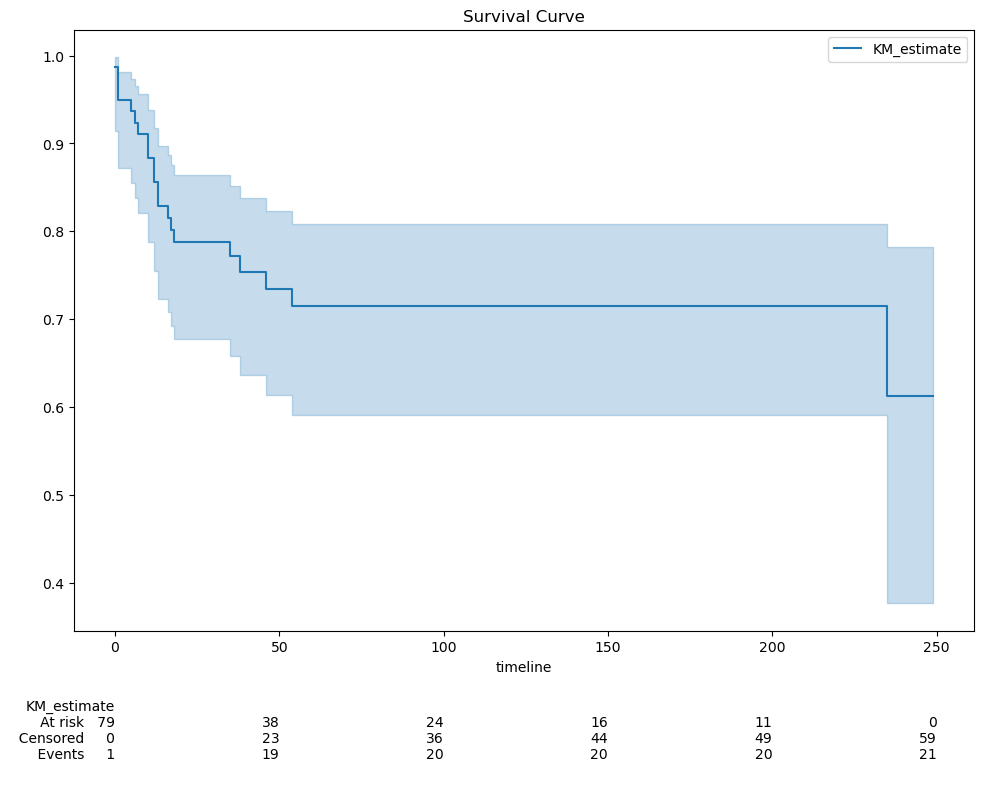

In [17]:
fig, ax = plt.subplots(figsize=(10,8)) 
kmf = KaplanMeierFitter()
kmf.fit(df1.Survival_months,
        event_observed=df1.Censor,
        )
ax.set_title("Survival Curve")
kmf.plot_survival_function(at_risk_counts=True,ax=ax)
plt.show()

## Logrank Test

In [19]:
km_features = df1.columns[2:]
km_features

Index(['Age', 'Sex', 'Year_of_diagnosis', 'PRCDA_2020', 'Race', 'Ethnicity',
       'Site', 'Laterality', 'Diagnostic_Confirmation', 'Rad_Seq',
       'Rural-Urban_Continuum_Code'],
      dtype='object')

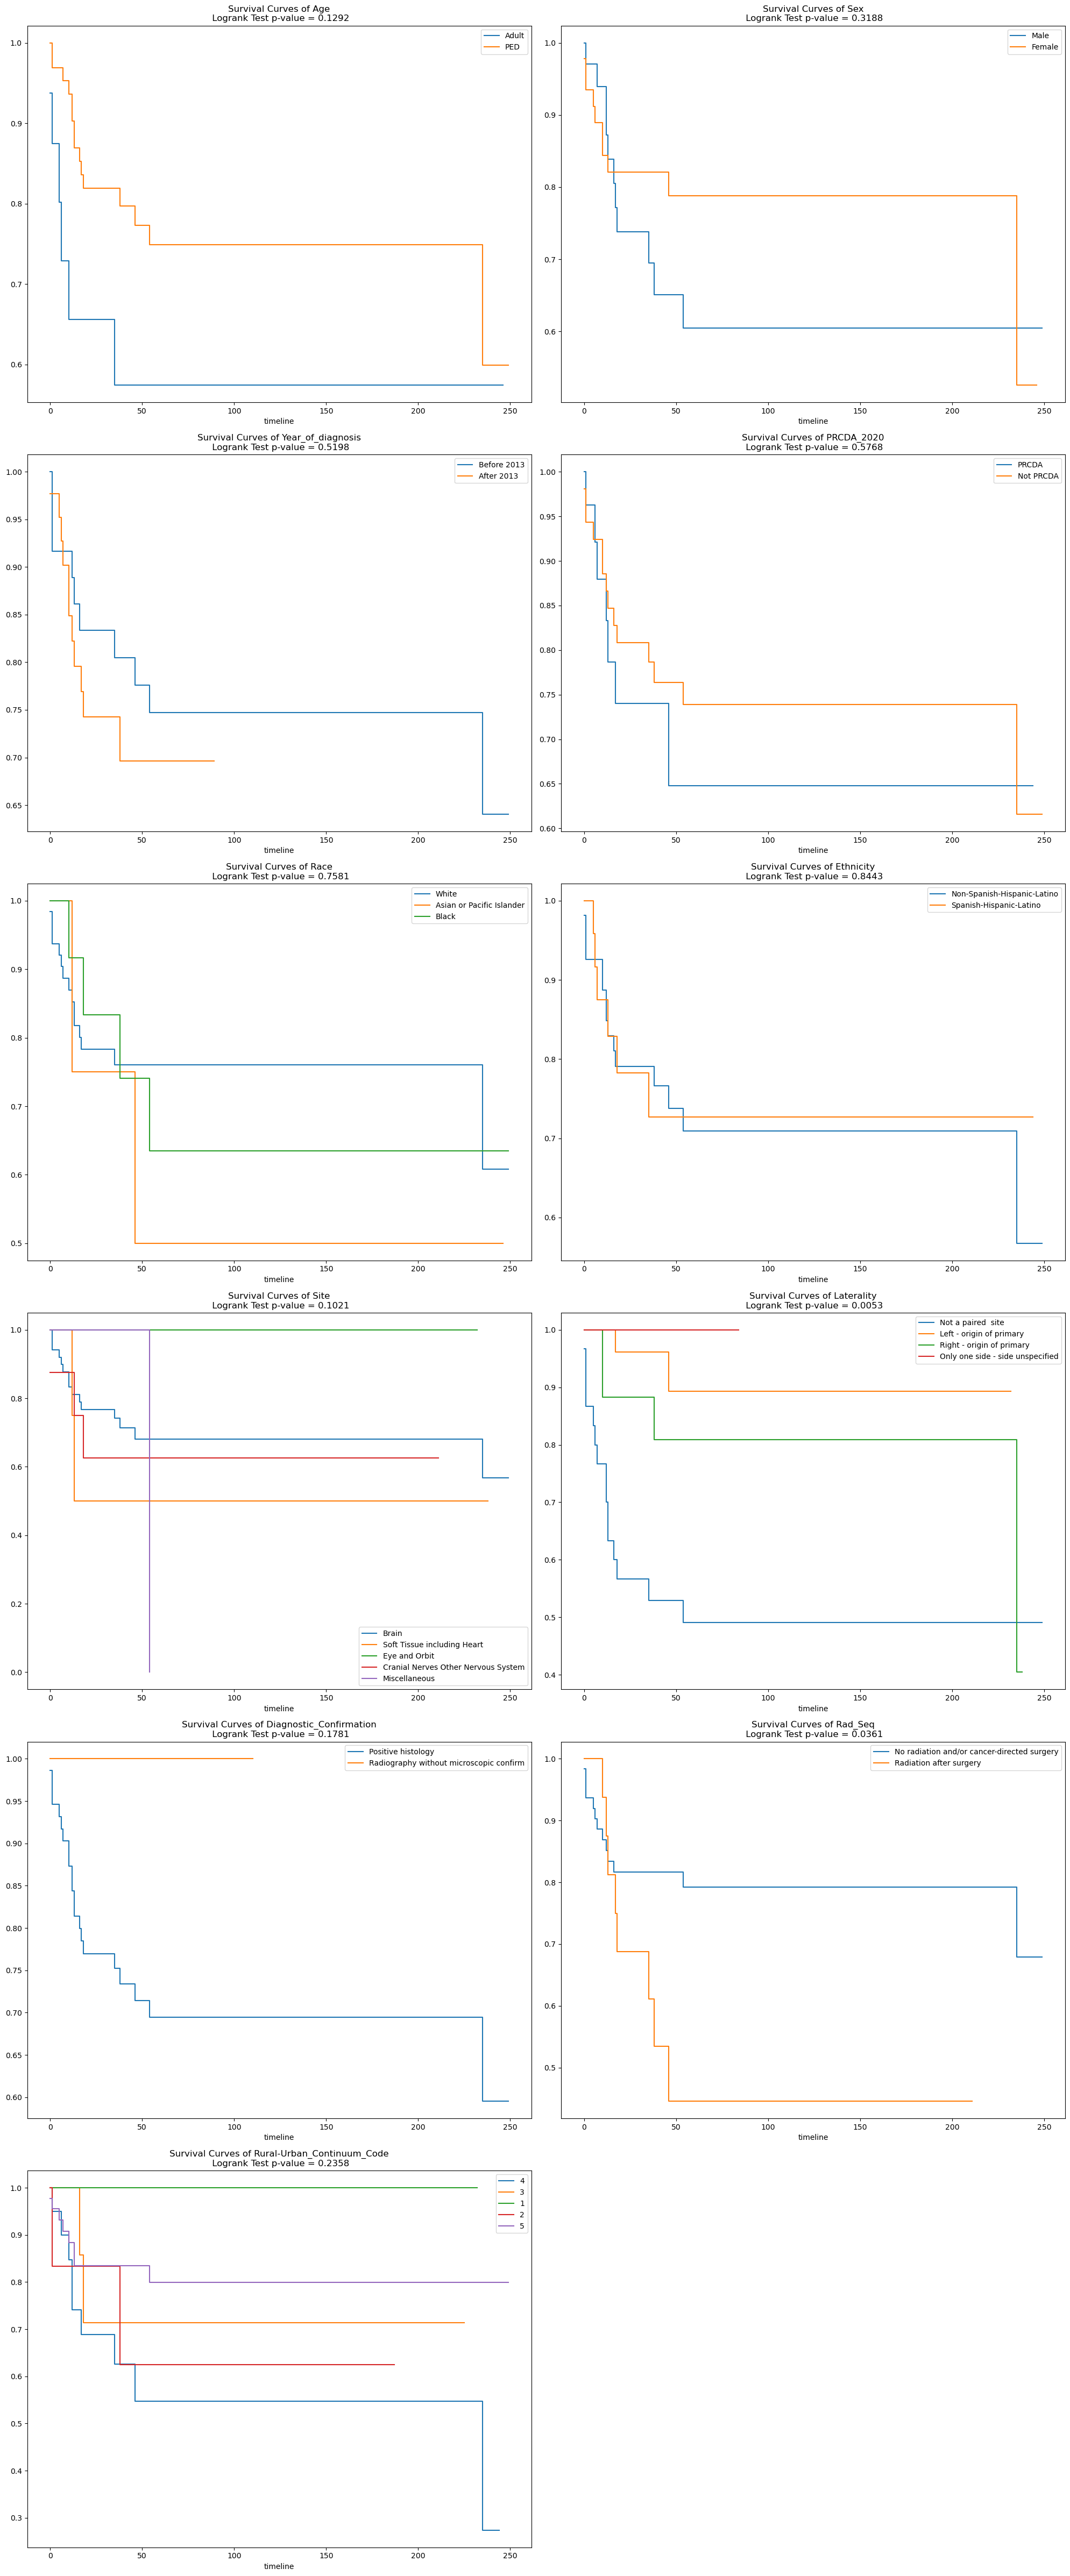

In [20]:
ncols = 2
nrows = int(len(km_features) / ncols) + (len(km_features) % ncols > 0)  # Calculate number of rows

# Create a figure with subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 8))  # Adjust figure size as needed

# Iterate through features and create KM curves and logrank tests
feature_idx = 0
for row in range(nrows):
    for col in range(ncols):
        if feature_idx >= len(km_features):
            break

        feature = km_features[feature_idx]
        ax = axes[row, col]  # Access the current subplot axis

        for i in df1[feature].unique():

            kmf=KaplanMeierFitter()  
            df_tmp = df1.loc[df1[feature] == i]
            kmf.fit(df_tmp.Survival_months,
                    event_observed=df_tmp.Censor,
                    label=i)

            kmf.plot_survival_function(ci_show=False, 
                                        ax = ax) 

        p_value = multivariate_logrank_test(event_durations = df1.Survival_months,
                                             groups=df1[feature],
                                            event_observed=df1.Censor
                                            ).p_value
        p_value_text = ['p-value < 0.001' if p_value < 0.001 else 'p-value = %.4F'%p_value][0]
        ax.set_title("Survival Curves of {}\n Logrank Test {}".format(feature, p_value_text))
        feature_idx += 1

if len(km_features) % ncols > 0:
    for col in range(len(km_features) % ncols, ncols):
        axes[nrows-1, col].axis('off')
        
# Adjust layout (optional)
plt.tight_layout()

# Show the figure
plt.show()

### Pairwise Comparison

In [22]:
pairwise_logrank_test(
        event_durations = df1.Survival_months,
        groups=df1.Laterality,
        event_observed=df1.Censor
)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                                                                   test_statistic      p  -log2(p)
Left - origin of primary         Not a paired  site                         11.57 <0.005     10.54
                                 Only one side - side unspecified            0.11   0.74      0.43
                                 Right - origin of primary                   0.87   0.35      1.51
Not a paired  site               Only one side - side unspecified            0.70   0.40      1.31
                                 Right - origin of primary                   3.47   0.06      4.00
Only one side - side unspecified Right - origin of primary                   0.21   0.65      0.63

## Stratified Logrank Test

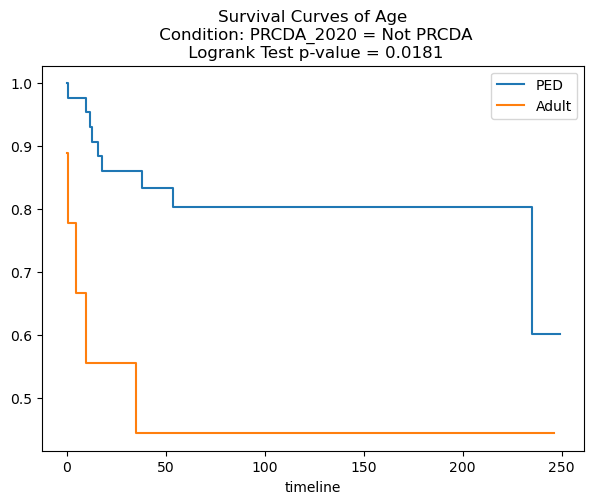

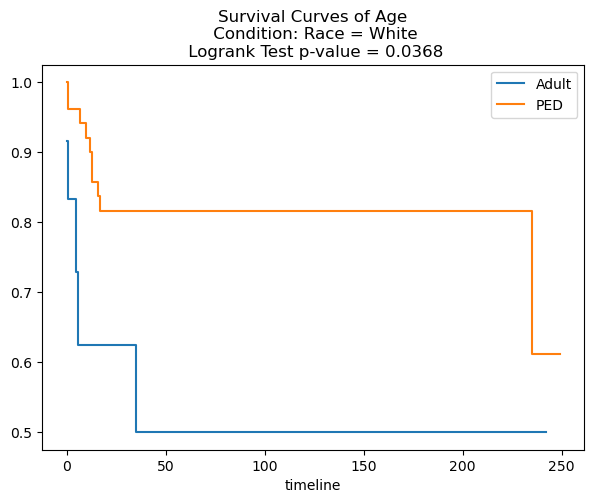

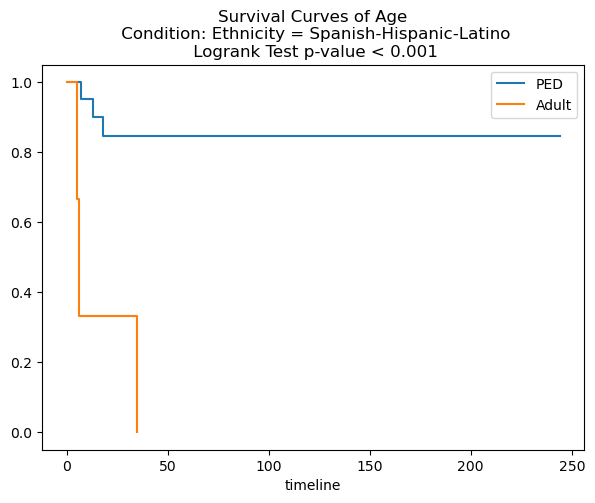

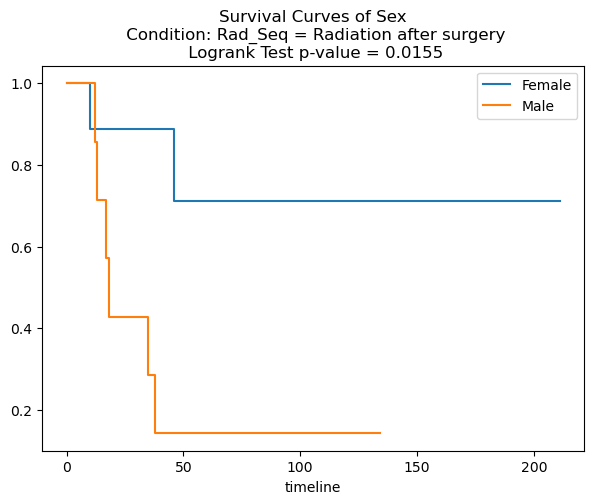

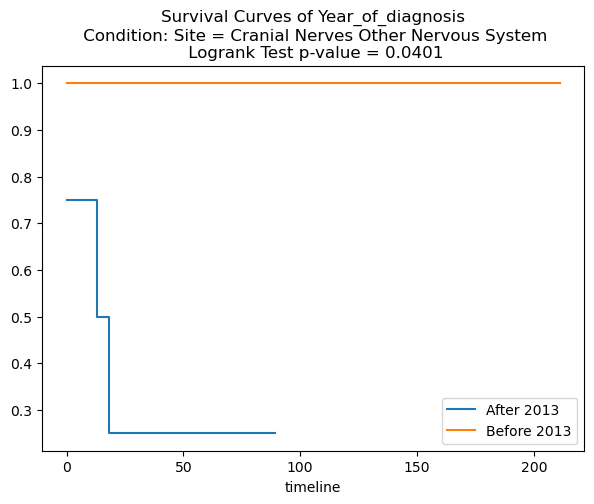

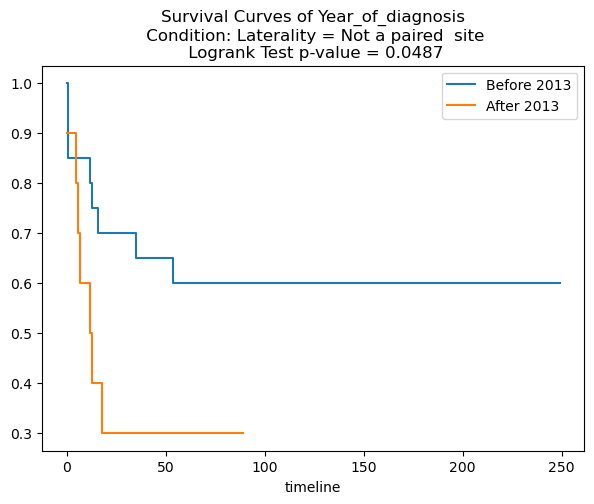

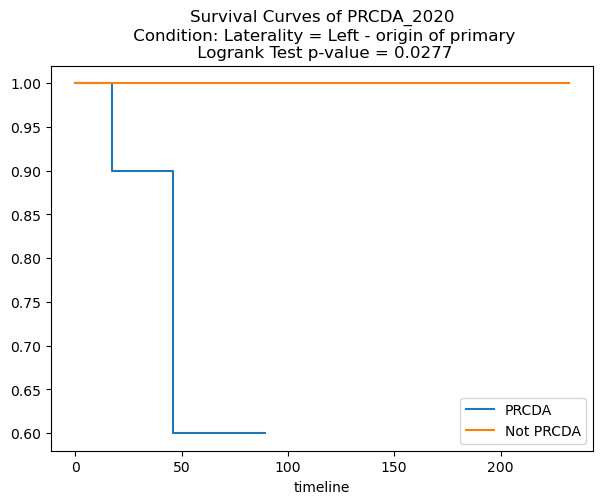

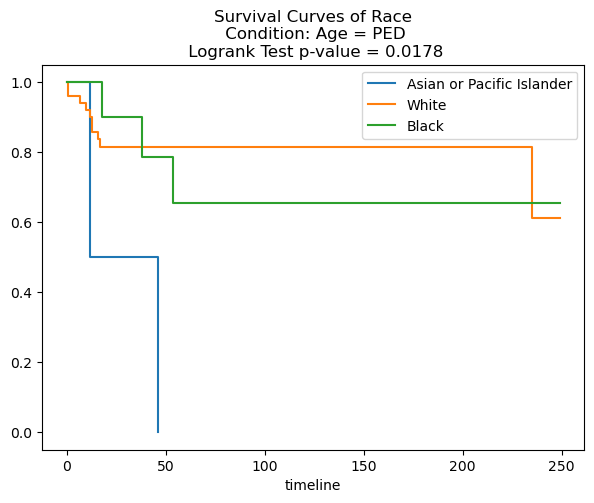

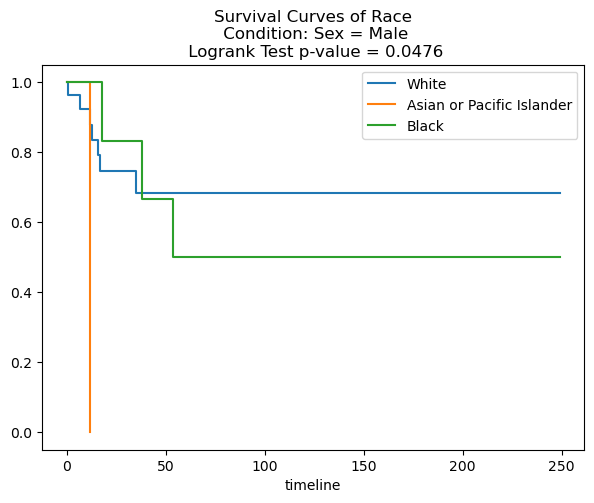

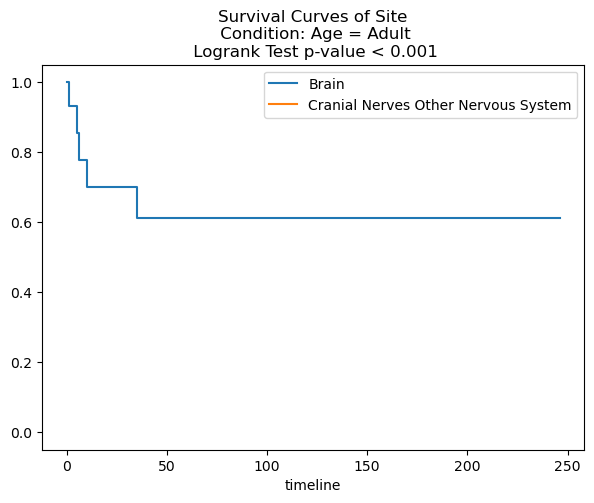

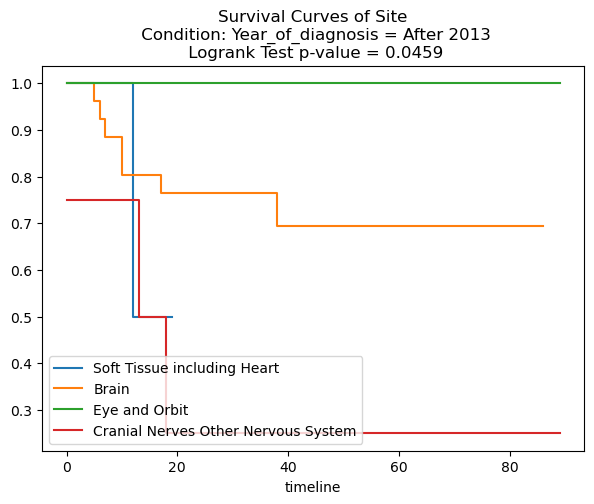

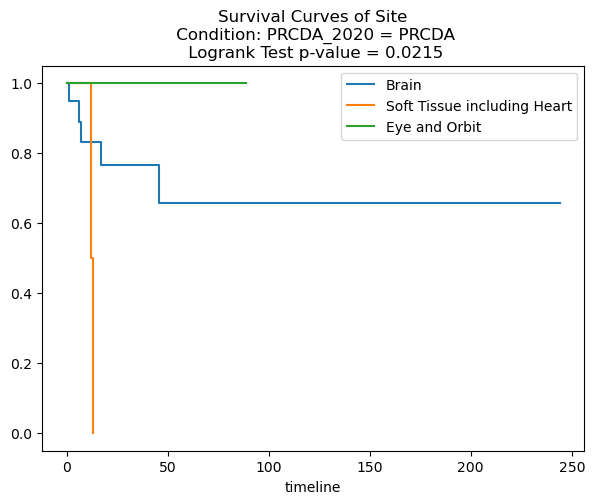

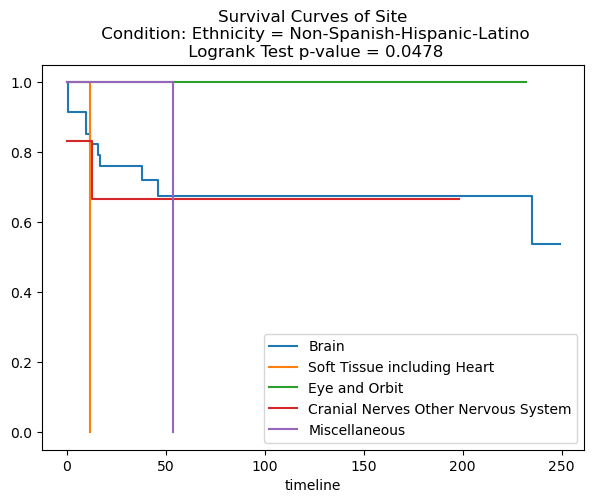

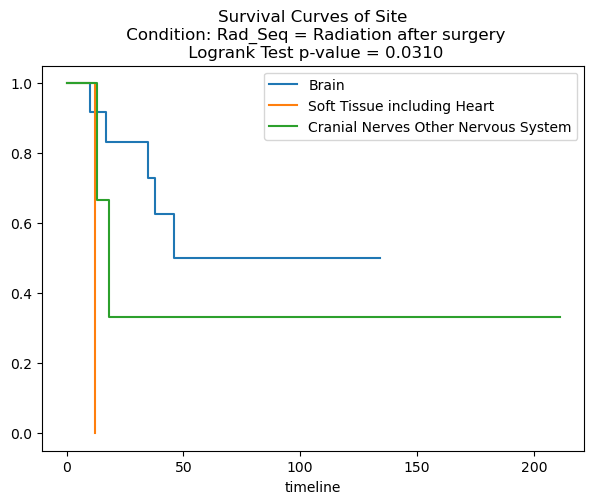

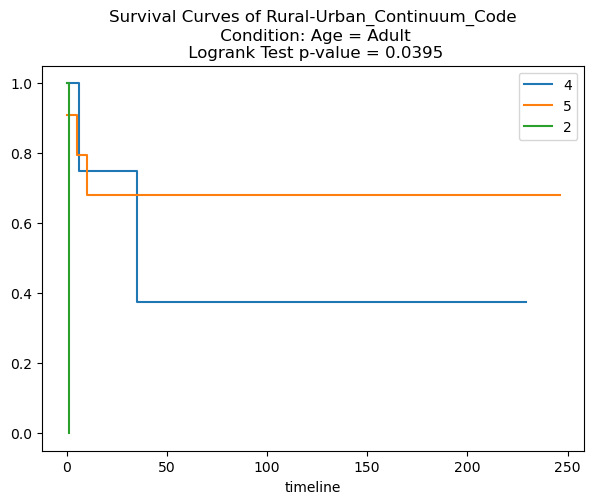

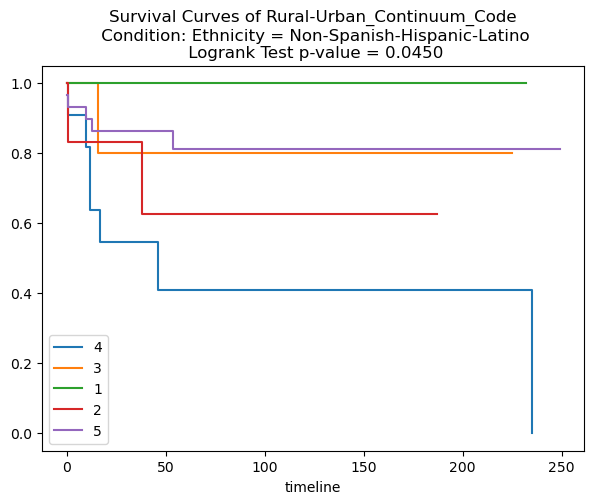

In [24]:
for refer in km_features.drop(['Laterality', 'Rad_Seq']):
    for feature in km_features.drop(refer):
        for i in df1[feature].unique():
            df_tmp = df1.loc[df1[feature] == i]
            if df_tmp[refer].nunique() == 1:
                break
            p_value = multivariate_logrank_test(event_durations = df_tmp.Survival_months,
                                                groups=df_tmp[refer],
                                                event_observed=df_tmp.Censor 
                                               ).p_value
            if p_value < 0.05:
                p_value_text = ['p-value < 0.001' if p_value < 0.001 else 'p-value = %.4F'%p_value][0]
                fig, ax = plt.subplots(figsize=(7,5))
                for j in df_tmp[refer].unique():
                    kmf=KaplanMeierFitter()  
                    df_tmp_tmp = df_tmp.loc[df_tmp[refer] == j]
                    kmf.fit(df_tmp_tmp.Survival_months,
                            event_observed=df_tmp_tmp.Censor,
                            label=j)
                    kmf.plot_survival_function(ci_show=False, ax = ax) 
                    ax.set_title("Survival Curves of {}\n Condition: {} = {}\n Logrank Test {}".format(refer, feature, i, p_value_text))

# Cox Regression

In [26]:
df2 = df.copy()
T = df2['Survival_months']
E = df2['Censor']

In [27]:
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 80 total observations, 59 right-censored observations>

<lifelines.CoxPHFitter: fitted with 80 total observations, 59 right-censored observations>
             duration col = 'Survival_months'
                event col = 'Censor'
                penalizer = 0.1
                 l1 ratio = 0.1
      baseline estimation = breslow
   number of observations = 80
number of events observed = 21
   partial log-likelihood = -77.08
         time fit was run = 2024-06-17 23:30:31 UTC

---
                                          coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                 
Age                                       0.01      1.01      0.01           -0.02            0.04                0.98                1.04
Sex                                      -0.01      0.99      0.41           -0.81            0.79                0.45                2.21
Year_of_diagnosis                         0.02      1.02      0.03           -0.05            0.08                0.95                1.08
PRCDA_2020                                0.18      1.20      0.43           -0.66            1.03                0.52                2.79
Ethnicity                                -0.20      0.82      0.42           -1.03            0.62                0.36                1.86
Diagnostic_Confirmation                   0.27      1.31      1.11           -1.91            2.46                0.15               11.66
Rad_Seq                                   0.48      1.61      0.47           -0.44            1.39                0.64                4.02
Rural-Urban_Continuum_Code               -0.17      0.84      0.20           -0.57            0.23                0.57                1.25
Race_Black                               -0.00      1.00      0.02           -0.05            0.05                0.95                1.05
Race_White                               -0.04      0.96      0.47           -0.96            0.88                0.38                2.41
Site_Brain                                0.00      1.00      0.05           -0.11            0.11                0.90                1.11
Site_Cranial Nerves Other Nervous System -0.00      1.00      0.01           -0.02            0.02                0.98                1.02
Site_Eye and Orbit                       -0.76      0.47      0.70           -2.12            0.61                0.12                1.83
Site_Soft Tissue including Heart          0.38      1.46      0.78           -1.15            1.91                0.32                6.78
Laterality_Left - origin of primary      -0.62      0.54      0.53           -1.66            0.42                0.19                1.52
Laterality_Not a paired  site             0.74      2.11      0.46           -0.15            1.64                0.86                5.17
Laterality_Right - origin of primary     -0.00      1.00      0.01           -0.01            0.01                0.99                1.01

                                          cmp to     z    p  -log2(p)
covariate                                                            
Age                                         0.00  0.63 0.53      0.93
Sex                                         0.00 -0.02 0.99      0.02
Year_of_diagnosis                           0.00  0.49 0.63      0.68
PRCDA_2020                                  0.00  0.43 0.67      0.58
Ethnicity                                   0.00 -0.49 0.63      0.67
Diagnostic_Confirmation                     0.00  0.25 0.81      0.31
Rad_Seq                                     0.00  1.02 0.31      1.69
Rural-Urban_Continuum_Code                  0.00 -0.84 0.40      1.33
Race_Black                                  0.00 -0.00 1.00      0.00
Race_White                                  0.00 -0.09 0.93      0.10
Site_Brain                                  0.00  0.00 1.00      0.00
Site_Cranial Nerves 

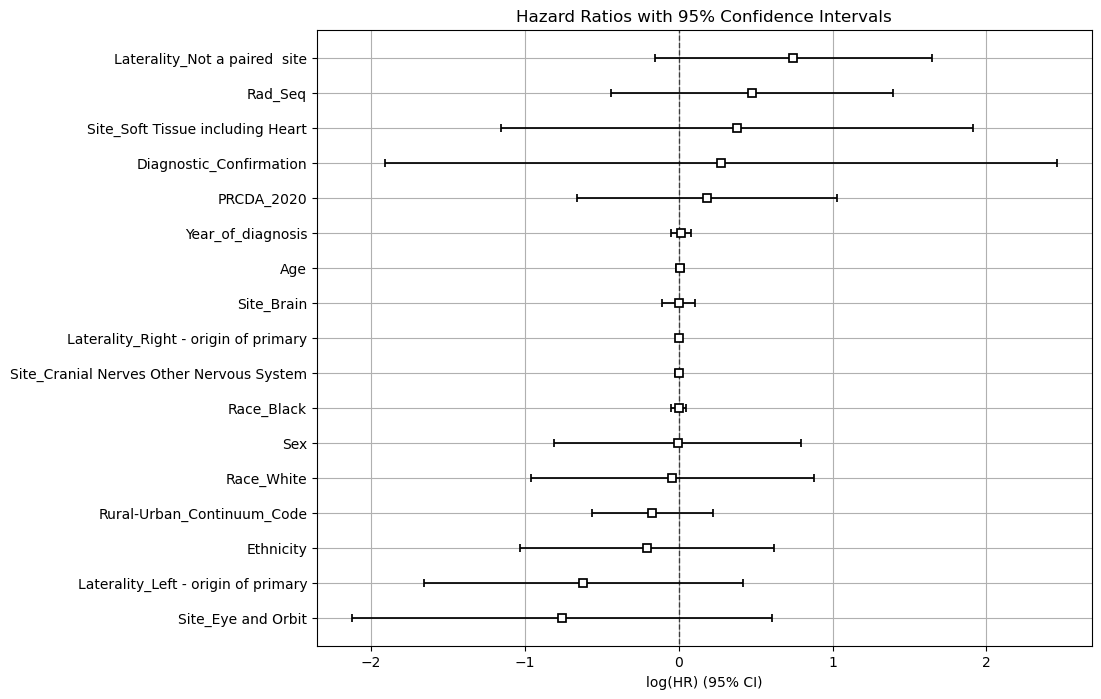

In [28]:
cph = CoxPHFitter(penalizer=0.1, l1_ratio=0.1)
df2['Survival_months'] = T
df2['Censor'] = E

cph.fit(df2, duration_col='Survival_months', event_col='Censor')

cph.print_summary()

plt.figure(figsize=(10, 8))
cph.plot()
plt.title('Hazard Ratios with 95% Confidence Intervals')
plt.grid(True)
plt.show()